# **Twitter Sentimental Analysis using Machine Learning Algorithms**

# Introduction

Sentiment analysis refers to identifying as well as classifying the sentiments that are expressed in the text source. Tweets are often useful in generating a vast amount of sentiment data upon analysis. These data are useful in understanding the opinion of the people about a variety of topics.

Therefore we need to develop an **Automated Machine Learning Sentiment Analysis Model** in order to compute the customer perception. Due to the presence of non-useful characters (collectively termed as the noise) along with useful data, it becomes difficult to implement models on them.

In this article, we aim to analyze the sentiment of the tweets provided from **the Sentiment140 dataset** by developing a machine learning pipeline involving the use of three classifiers **(Logistic Regression, Bernoulli Naive Bayes, and SVM)** along with using **Term Frequency- Inverse Document Frequency (TF-IDF)**. The performance of these classifiers is then evaluated using **accuracy** and **F1 Scores.**

# Problem Statement

In this project, we try to implement a **Twitter sentiment analysis** model that helps to overcome the challenges of identifying the sentiments of the tweets. The necessary details regarding the dataset are:

The dataset provided is the **Sentiment Dataset** which consists of 50,000 tweets that have been extracted using the Twitter API. The various columns present in the dataset are:

* **target**: the polarity of the tweet (positive or negative)
* **ids**: Unique id of the tweet
* **date**: the date of the tweet
* **flag**: It refers to the query. If no such query exists then it is NO QUERY.
* **user**: It refers to the name of the user that tweeted
* **text**: It refers to the text of the tweet

# Project pipeline

The various steps involved in the **Machine Learning Pipeline** are :

* Import Necessary Dependencies
* Read and Load the Dataset
* Exploratory Data Analysis
* Data Visualization of Target Variables
* Data Preprocessing
* Splitting our data into Train and Test Subset
* Transforming Dataset using TF-IDF Vectorizer
* Function for Model Evaluation
* Model Building
* Conclusion

# Import Necessary Dependencies

In [ ]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import warnings 
pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# **Read and Load the Dataset**

In [ ]:
df  = pd.read_csv('../input/twitter-dinesh-train/train_av.csv') 
dftest = pd.read_csv('../input/twitter-dinesh-train/test_av1.csv')

# **Exploratory Data Analysis **

In [ ]:
df.head(10)

In [ ]:
df[df['label'] == 0].head(10)

In [ ]:
df[df['label'] == 1].head(10)

In [ ]:
df.head()

**Columns/features in data**

In [ ]:
df.columns

In [ ]:
print('length of data is', len(df)) #1048576

In [ ]:
df. shape

In [ ]:
df.info()

In [ ]:
df.dtypes

In [ ]:
np.sum(df.isnull().any(axis=1))

In [ ]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

In [ ]:
df['label'].unique()

In [ ]:
df['label'].nunique()

In [ ]:
dftest.head()

In [ ]:
print('length of data is', len(dftest)) #1048576

In [ ]:
dftest. shape

In [ ]:
dftest.info()

# **Plotting data**

In [ ]:
cnt1 = len(df[df['label']==1])
cnt0 = len(df[df['label']==0])
pct0 = cnt0/(cnt1+cnt0)
print('percent 0',round(pct0*100,2))
pct1 = cnt1/(cnt0+cnt1)
print('percent 1',round(pct1*100,2))
print(cnt1)
print(cnt0)

In the train dataset, we have 2,242 (~7%) tweets labeled as racist or sexist, and 29,720 (~93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification challenge.


In [ ]:
ax=pd.value_counts(df['label']).plot.bar()
#for multiple colours with tweet data
#ax = df.groupby('label').count().plot(kind='bar', title='Distribution of data',legend=False)
plt.title('Distribution')
ax.set_xticklabels(['Negative','Positive'], rotation=0)
plt.xlabel('label')
plt.ylabel('counts')
plt.legend()
plt.show()

In [ ]:
data=df[['tweet','label']]
data['label'] = data['label'].replace(4,1)
data['label'].unique()


Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

In [ ]:
plt.hist(df.tweet.str.len(), bins=20, label='train')
plt.hist(dftest.tweet.str.len(), bins=20, label='test')
plt.legend()
plt.show()

In [ ]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
df['word count'] = df['tweet'].apply(word_count)
df.head(3)


Now let us plot a bar graph positive and negative tweets according word count in the tweet

In [ ]:
x = df['word count'][df.label == 1]
y = df['word count'][df.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In any natural language processing task, cleaning raw text data is an important step. It helps in getting rid of the unwanted words and characters which helps in obtaining better features. If we skip this step then there is a higher chance that you are working with noisy and inconsistent data. The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.

#  **Understanding the impact of Hashtags on tweets sentiment**

In [ ]:
combi = df.append(df, ignore_index=True, sort=True)
combi.shape

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

For instance, given below is a tweet from our dataset:

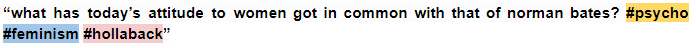

The tweet seems sexist in nature and the hashtags in the tweet convey the same feeling.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.

In [ ]:
def hashtag_extract(x):
    hashtags = []    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [ ]:
data = df.append(dftest,ignore_index=True)

In [ ]:
# extracting hashtags from non racist/sexist tweets 

HT_regular = hashtag_extract(data['tweet'][data['label'] == 0])

In [ ]:
# extracting hashtags from racist/sexist tweets 

HT_negative = hashtag_extract(combi['tweet'][combi['label'] == 1])

In [ ]:
# unnesting list

HT_regular = sum(HT_regular,[]) 
HT_negative = sum(HT_negative,[])

# **Non-Racist/Sexist Tweets**

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top ‘n’ hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

In [ ]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
) 
print(a)

In [ ]:
# selecting top 20 most frequent hashtags

d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
# plt.xticks(rotation=90)
plt.show()

# **Racist/Sexist Tweets**

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

In [ ]:
b = nltk.FreqDist(HT_negative)
d = pd.DataFrame(
    {
    'Hashtag': list(b.keys()),
    'Count': list(b.values())
    }
) 
print(a)

In [ ]:
# selecting top 20 most frequent hashtags

d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
# plt.xticks(rotation=90)
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

# **CLEANING TWEET DATA**

Given below is a user-defined function to remove unwanted text patterns from the tweets.

Before we begin cleaning, let’s first combine train and test datasets. Combining the datasets will make it convenient for us to preprocess the data. Later we will split it back into train and test data.

In [ ]:
combi = df.append(df, ignore_index=True, sort=True)
combi.shape

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

We will be following the steps below to clean the raw tweets in out data.

We will remove the twitter handles as they are already masked as @user due to privacy concerns. These twitter handles hardly give any information about the nature of the tweet.

We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

**Removing Twitter Handles (@user)**

Let’s create a new column tidy_tweet, it will contain the cleaned and processed tweets. Note that we have passed “@[]*” as the pattern to the remove_pattern function. It is actually a regular expression which will pick any word starting with ‘@’.

In [ ]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") 
combi.head(10)

**Removing Punctuations, Numbers, and Special Characters**

Here we will replace everything except characters with spaces. The regular expression “[^a-zA-Z]” means anything except alphabets.

In [ ]:
combi.tidy_tweet = combi.tidy_tweet.str.replace("[^a-zA-Z]", " ")
combi.head(10)

**Removing Short Words**

We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [ ]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
combi.head(10)


You can see the difference between the raw tweets and the cleaned tweets (tidy_tweet) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

# **Text Normalization**

Here we will use nltk’s PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [ ]:
tokenized_tweet = combi.tidy_tweet.apply(lambda x: x.split())
tokenized_tweet.head()

In [ ]:
# Now we can normalize the tokenized tweets.

from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

In [ ]:
# Now let’s stitch these tokens back together. It can easily be done using nltk’s MosesDetokenizer function.

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
combi['tidy_tweet'] = tokenized_tweet
combi.head(10)

In this section, we will explore the cleaned tweets. Exploring and visualizing data, no matter whether its text or any other data, is an essential step in gaining insights. Do not limit yourself to only these methods told in this course, feel free to explore the data as much as possible.

Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

* What are the most common words in the entire dataset?
* What are the most common words in the dataset for negative and positive tweets, respectively?
* How many hashtags are there in a tweet?
* Which trends are associated with my dataset?
* Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

# **WORD CLOUD**

**Understanding the common words used in the tweets: WordCloud**

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

**plot a cloud of word for top 100 words in the tweets**

In [ ]:
all_words = ' '.join([str(text) for text in combi['tidy_tweet']])

from wordcloud import WordCloud,STOPWORDS
#stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    width=800, 
    height=500,
    #stopwords=stopwords,
    background_color='white',
    random_state=21, 
    max_font_size=130,#maximum fount size in word cloud
    max_words=100 #no. of word can be place there
).generate(all_words) 
plt.figure(figsize=(15,15)) #size of word cloud
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()


We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

**plot a cloud of word for all the words in the tweets**

In [ ]:
all_words1 = ' '.join([str(text) for text in combi['tidy_tweet']])

from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    width=800, 
    height=500,
    stopwords=stopwords,
    background_color='white',
    random_state=21, 
    max_font_size=130,#maximum fount size in word cloud
    #max_words=100 #no. of word can be place there
).generate(all_words1) 
plt.figure(figsize=(15,15)) #size of word cloud
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()


We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

**Plot a cloud of words for positive tweets**

In [ ]:
Postive_tweet =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]]) 
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    width=800, 
    height=500,
    stopwords=stopwords,
    background_color='white',
    random_state=21, 
    max_font_size=130,#maximum fount size in word cloud
    #max_words=100 #no. of word can be place there
).generate(Postive_tweet) 
plt.figure(figsize=(15,15)) #size of word cloud
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()


Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

**Plot a cloud of words for negative tweets**

In [ ]:
Negative_tweet =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    width=800, 
    height=500,
    stopwords=stopwords,
    background_color='white',
    random_state=21, 
    max_font_size=130,#maximum fount size in word cloud
    #max_words=100 #no. of word can be place there
).generate(Negative_tweet) 
plt.figure(figsize=(15,15)) #size of word cloud
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()


As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

# **Splitting our data into Train and Test Subset**

In [ ]:
X=combi.tweet
y=combi.label

In [ ]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

# ***Transforming Dataset using TF-IDF Vectorizer***

**Fit the TF-IDF Vectorizer**

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

**Transform the data using TF-IDF Vectorizer**

In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# **Function For Model Evaluation**

After training the model we then apply the evaluation measures to check how the model is performing. Accordingly, we use the following evaluation parameters to check the performance of the models respectively :

* Accuracy Score
* Confusion Matrix with Plot
* ROC-AUC Curve

In [ ]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred= model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# ***Model Building***

In the problem statement we have used three different models respectively :

* Bernoulli Naive Bayes
* SVM (Support Vector Machine)
* Logistic Regression

The idea behind choosing these models is that we want to try all the classifiers on the dataset ranging from simple ones to complex models and then try to find out the one which gives the best performance among them.

**Model1:Bernoulli Naive Bayes model**

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

**Plot the ROC-AUC Curve for model-1**

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**Model2: SVM (Support Vector Machine) model**

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

***Plot the ROC-AUC Curve for model-2***

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**Model-3 Logistic Regression model**

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

**Plot the ROC-AUC Curve for model-3**

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# **conclusion:**

Upon evaluating all the models we can conclude the following details i.e.

**Accuracy:** As far as the accuracy of the model is concerned Logistic Regression performs better than SVM which in turn performs better than Bernoulli Naive Bayes.

**F1-score:** The F1 Scores for class 0 and class 1 are :

(a) For class 0: Logistic Regression (accuracy = 0.98)< Bernoulli Naive Bayes(accuracy = 0.98) < SVM (accuracy =1.00) 

(b) For class 1: Logistic Regression (accuracy = 0.65)< Bernoulli Naive Bayes (accuracy = 0.69) < SVM (accuracy = 0.98) 

**AUC Score:** All three models have the same ROC-AUC score.

We, therefore, conclude that the SVM is the best model for the above-given dataset.

In our problem statement, **SVM Support-vector machine** is following the principle of **Occam’s Razor** which defines that for a particular problem statement if the data has no assumption, then the simplest model works the best. Since our dataset does not have any assumptions and SVM is a simple model, therefore the concept holds true for the above-mentioned dataset